In [1]:
from lsst.daf.butler import Butler
import numpy as np
from lsst.meas.base import ForcedMeasurementTask, ForcedMeasurementConfig
import lsst.geom as geom
import lsst.afw.table as afwTable
from lsst.summit.utils import ConsDbClient
from astropy import units as u
import matplotlib.pyplot as plt

In [2]:
butler = Butler("embargo",collections='u/rea3/too_0725J/SN10//20250814T211435Z')

In [3]:
# name ra dec
# AT2025shz   231.072434 -37.622634
# AT2025sib   235.548892 -35.002876
# AT2025sia   234.538140 -36.254760
# AT2025srk  234.755524  -36.425993
# AT2025srl  234.90473   -36.726032
# AT2025srm  232.987656  -36.816564

names = ['AT2025shz', 'AT2025sib', 'AT2025sia', 'AT2025srk', 'AT2025srl', 'AT2025srm']
ras = np.array([231.072434, 235.548892, 234.538140, 234.755524, 234.90473, 232.987656])
decs = np.array([-37.622634, -35.002876, -36.254760, -36.425993, -36.726032, -36.816564])
ids = np.arange(0,6)


In [4]:
schema = afwTable.SourceTable.makeMinimalSchema()
table = afwTable.SourceTable.make(schema)

forced_config = ForcedMeasurementConfig()

forced_config.plugins.names = [
    "base_PixelFlags",
    "base_TransformedCentroidFromCoord",
    "base_PsfFlux",
    "base_LocalBackground",                     
]
forced_config.slots.shape = None
forced_config.copyColumns = {'id': 'diaObjectId', 'coord_ra': 'coord_ra', 'coord_dec': 'coord_dec'}
forced_config.slots.centroid = "base_TransformedCentroidFromCoord"
forced_config.slots.psfFlux = "base_PsfFlux"
forced_config.doReplaceWithNoise = False

forced_task = ForcedMeasurementTask(config=forced_config, refSchema=schema)

In [5]:
explist = [2025072800100, ]

In [6]:
ExpsOfInterest = """instrument exposure detector
2025072800105 25
2025072800115 25
2025072800125 25
2025072800135 25
2025072800145 25
2025072800155 25
2025072800104 170
2025072800114 170
2025072800124 170
2025072800134 170
2025072800144 170
2025072800154 170
2025072800105 21
2025072800115 21
2025072800125 21
2025072800135 21
2025072800145 21
2025072800155 21
2025072800104 167
2025072800114 167
2025072800124 167
2025072800134 167
2025072800144 167
2025072800154 167
2025072800104 185
2025072800114 185
2025072800124 185
2025072800134 185
2025072800144 185
2025072800154 185
2025072800100 131
2025072800110 131
2025072800120 131
2025072800130 131
2025072800140 131
2025072800150 131
2025072800105 97
2025072800115 97
2025072800125 97
2025072800135 97
2025072800145 97
2025072800155 97
2025072800105 56
2025072800115 56
2025072800125 56
2025072800135 56
2025072800145 56
2025072800155 56"""

In [7]:
ToOExps = np.array([x.split(" ") for x in ExpsOfInterest.split("\n")][1:])

In [8]:
ToOExps

array([['2025072800105', '25'],
       ['2025072800115', '25'],
       ['2025072800125', '25'],
       ['2025072800135', '25'],
       ['2025072800145', '25'],
       ['2025072800155', '25'],
       ['2025072800104', '170'],
       ['2025072800114', '170'],
       ['2025072800124', '170'],
       ['2025072800134', '170'],
       ['2025072800144', '170'],
       ['2025072800154', '170'],
       ['2025072800105', '21'],
       ['2025072800115', '21'],
       ['2025072800125', '21'],
       ['2025072800135', '21'],
       ['2025072800145', '21'],
       ['2025072800155', '21'],
       ['2025072800104', '167'],
       ['2025072800114', '167'],
       ['2025072800124', '167'],
       ['2025072800134', '167'],
       ['2025072800144', '167'],
       ['2025072800154', '167'],
       ['2025072800104', '185'],
       ['2025072800114', '185'],
       ['2025072800124', '185'],
       ['2025072800134', '185'],
       ['2025072800144', '185'],
       ['2025072800154', '185'],
       ['2025072800100

In [9]:
zpArr = []
expsFound = []
band = []

for e in ToOExps:
    exp = int(e[0])
    det = int(e[1])
    try:
        diff_refs = list(butler.query_datasets(
          "difference_image",
          where=f"exposure={exp} and instrument='LSSTCam' and detector={det}"
        ))
    except:
        continue
    
    bbox = butler.get(
        "difference_image.bbox",
        dataId=diff_refs[0].dataId
    )
    wcs = butler.get(
        "difference_image.wcs",
        dataId=diff_refs[0].dataId
    )                    

    found = np.array([False]*len(ras))
    for i,(ra,dec) in enumerate(zip(ras,decs)):
        if bbox.contains(geom.Point2I(wcs.skyToPixel(geom.SpherePoint(ra,dec,geom.degrees)))):
            found[i] = True
    n_src = np.sum(found==True)
    n_mask = found == True
    if n_src == 0:
        continue
    print('Found',exp, det, n_src, 'sources')
    expsFound.append([exp,det])
    diff = butler.get('difference_image', dataId=diff_refs[0].dataId)
    temp = butler.get('template_matched', dataId=diff_refs[0].dataId)
    sci = butler.get('preliminary_visit_image', dataId=diff_refs[0].dataId)

    zp = []
    for i in [diff,temp,sci]:
        zp.append(i.getPhotoCalib().getInstFluxAtZeroMagnitude())
    zpArr.append(zp)
    band.append(diff_refs[0].dataId["band"])

    schema = afwTable.SourceTable.makeMinimalSchema()
    ref_catalog = afwTable.SourceCatalog(schema)
    ref_catalog.reserve(n_src)

    if (e==ToOExps[0]).all(): # If this is the first forced source measurement, instantiate the master catalog
        tempMasterCat = afwTable.SourceCatalog(forced_task.generateMeasCat(temp, ref_catalog, 
                                                                           temp.getWcs()).getSchema()).asAstropy()
        sciMasterCat = afwTable.SourceCatalog(forced_task.generateMeasCat(sci, ref_catalog, 
                                                                          sci.getWcs()).getSchema()).asAstropy()
        diffMasterCat = afwTable.SourceCatalog(forced_task.generateMeasCat(diff, ref_catalog, 
                                                                           diff.getWcs()).getSchema()).asAstropy()

    for object_id, ra, dec in zip(ids[n_mask],ras[n_mask],decs[n_mask]):
        record = ref_catalog.addNew()
        record.setId(object_id)
        record.setCoord(geom.SpherePoint(ra, dec, geom.degrees))

    # Generate forced photometry catalogs
    forced_sci_cat = forced_task.generateMeasCat(sci, ref_catalog, sci.getWcs())
    forced_diff_cat = forced_task.generateMeasCat(diff, ref_catalog, diff.getWcs())
    forced_temp_cat = forced_task.generateMeasCat(temp, ref_catalog, temp.getWcs())

    # Attach footprints to the catalogs - just use PSF
    forced_task.attachPsfShapeFootprints(forced_sci_cat, sci)
    forced_task.attachPsfShapeFootprints(forced_diff_cat, diff)
    # Use psf size of the difference image, because template PSF is somewhat arbitrary
    forced_task.attachPsfShapeFootprints(forced_temp_cat, diff)

    forced_task.run(forced_sci_cat, sci, ref_catalog, sci.getWcs())
    forced_task.run(forced_diff_cat, diff, ref_catalog, diff.getWcs())
    forced_task.run(forced_temp_cat, temp, ref_catalog, temp.getWcs())

    # Append results to the master catalog
    tempMasterCat.add_row(forced_temp_cat.asAstropy()[-1])
    sciMasterCat.add_row(forced_sci_cat.asAstropy()[-1])
    diffMasterCat.add_row(forced_diff_cat.asAstropy()[-1])

Found 2025072800105 25 1 sources


Found 2025072800115 25 1 sources


Found 2025072800135 25 1 sources


Found 2025072800145 25 1 sources


Found 2025072800104 170 1 sources


Found 2025072800114 170 1 sources


Found 2025072800134 170 1 sources


Found 2025072800144 170 1 sources


Found 2025072800105 21 1 sources


Found 2025072800115 21 1 sources


Found 2025072800135 21 1 sources


Found 2025072800145 21 1 sources


Found 2025072800104 167 1 sources


Found 2025072800114 167 1 sources


Found 2025072800134 167 1 sources


Found 2025072800144 167 1 sources


Found 2025072800104 185 1 sources


Found 2025072800114 185 1 sources


Found 2025072800134 185 1 sources


Found 2025072800144 185 1 sources


Found 2025072800100 131 1 sources


Found 2025072800110 131 1 sources


Found 2025072800130 131 1 sources


Found 2025072800140 131 1 sources


Found 2025072800105 97 1 sources


Found 2025072800115 97 1 sources


Found 2025072800135 97 1 sources


Found 2025072800145 97 1 sources


Found 2025072800105 56 1 sources


Found 2025072800115 56 1 sources


Found 2025072800135 56 1 sources


Found 2025072800145 56 1 sources


In [10]:
def fluxToMag(flux,zpFlux):
    return -2.5*np.log10(flux/zpFlux)

def fluxErrToMagErr(flux,fluxErr):
    """
    This assumes that sigma_zp/zp ~ 0, which feels like a safe assumption to make right now
    """
    return abs(2.5 / np.log(10) * fluxErr/flux)

In [11]:
diffMasterCat["zeroPoint"] = np.array(zpArr)[:,0] * u.ct
tempMasterCat["zeroPoint"] = np.array(zpArr)[:,1] * u.ct
sciMasterCat["zeroPoint"] = np.array(zpArr)[:,2] * u.ct

In [12]:
diffMasterCat["baseSourceMag"] = fluxToMag(diffMasterCat["base_PsfFlux_instFlux"],diffMasterCat["zeroPoint"])
diffMasterCat["slotSourceMag"] = fluxToMag(diffMasterCat["slot_PsfFlux_instFlux"],diffMasterCat["zeroPoint"])
sciMasterCat["baseSourceMag"] = fluxToMag(sciMasterCat["base_PsfFlux_instFlux"],sciMasterCat["zeroPoint"])
sciMasterCat["slotSourceMag"] = fluxToMag(sciMasterCat["slot_PsfFlux_instFlux"],sciMasterCat["zeroPoint"])
tempMasterCat["baseSourceMag"] = fluxToMag(tempMasterCat["base_PsfFlux_instFlux"],tempMasterCat["zeroPoint"])
tempMasterCat["slotSourceMag"] = fluxToMag(tempMasterCat["slot_PsfFlux_instFlux"],tempMasterCat["zeroPoint"])

/tmp/ipykernel_39157/994719148.py:2: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux/zpFlux)


In [13]:
diffMasterCat["baseSourceMagErr"] = fluxErrToMagErr(diffMasterCat["base_PsfFlux_instFlux"],diffMasterCat["base_PsfFlux_instFluxErr"])
diffMasterCat["slotSourceMagErr"] = fluxErrToMagErr(diffMasterCat["slot_PsfFlux_instFlux"],diffMasterCat["slot_PsfFlux_instFluxErr"])
sciMasterCat["baseSourceMagErr"] = fluxErrToMagErr(sciMasterCat["base_PsfFlux_instFlux"],sciMasterCat["base_PsfFlux_instFluxErr"])
sciMasterCat["slotSourceMagErr"] = fluxErrToMagErr(sciMasterCat["slot_PsfFlux_instFlux"],sciMasterCat["slot_PsfFlux_instFluxErr"])
tempMasterCat["baseSourceMagErr"] = fluxErrToMagErr(tempMasterCat["base_PsfFlux_instFlux"],tempMasterCat["base_PsfFlux_instFluxErr"])
tempMasterCat["slotSourceMagErr"] = fluxErrToMagErr(tempMasterCat["slot_PsfFlux_instFlux"],tempMasterCat["slot_PsfFlux_instFluxErr"])

In [14]:
diffMasterCat["band"] = band
sciMasterCat["band"] = band
tempMasterCat["band"] = band

## Make some plots

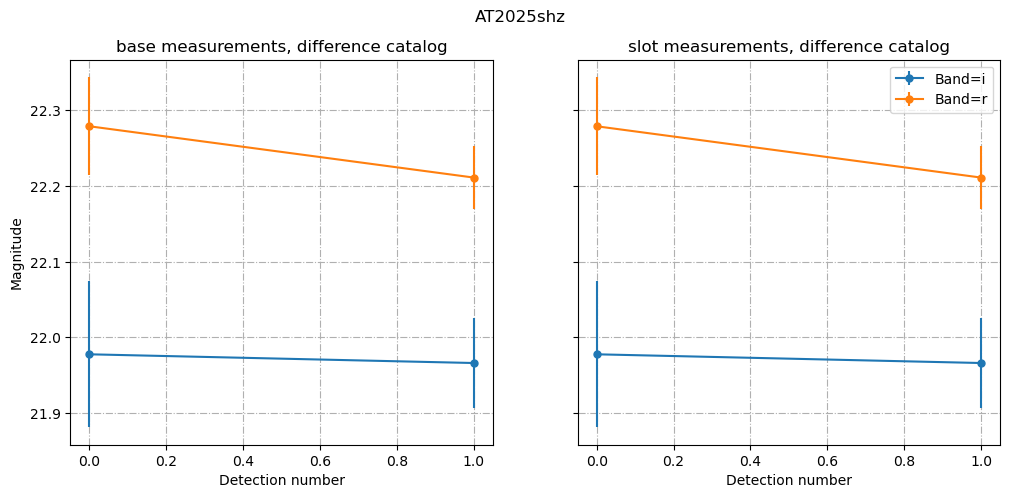

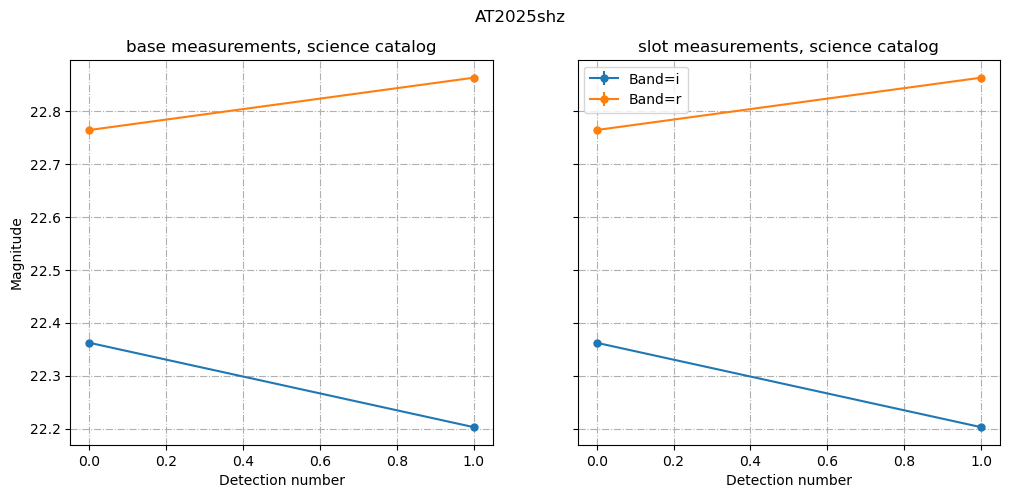

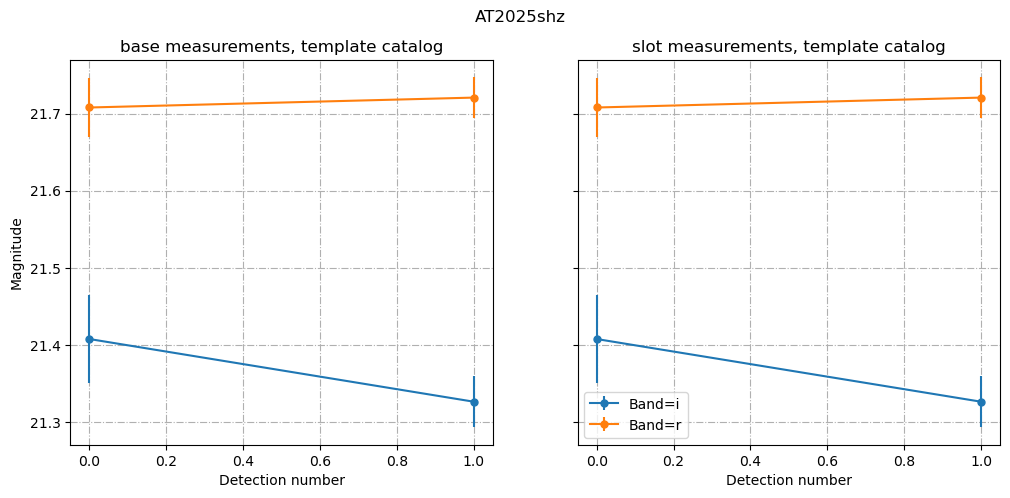

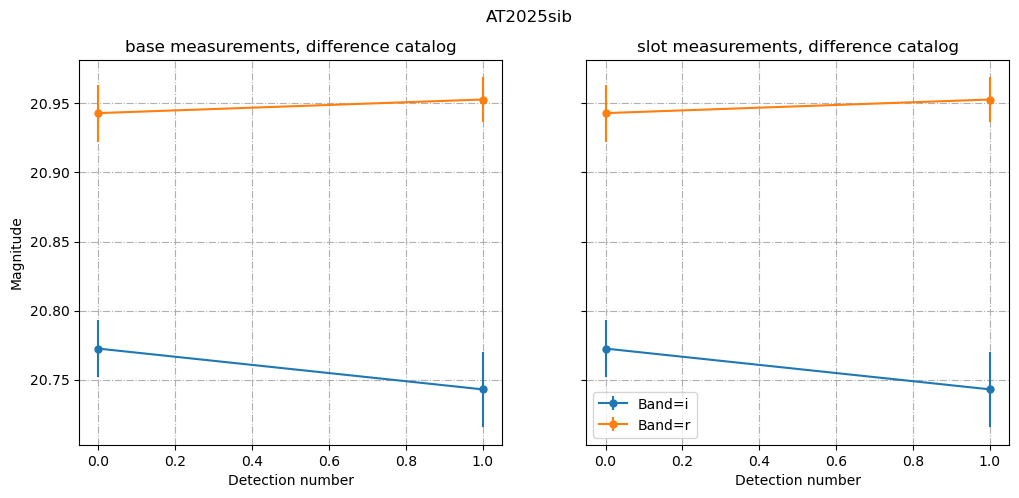

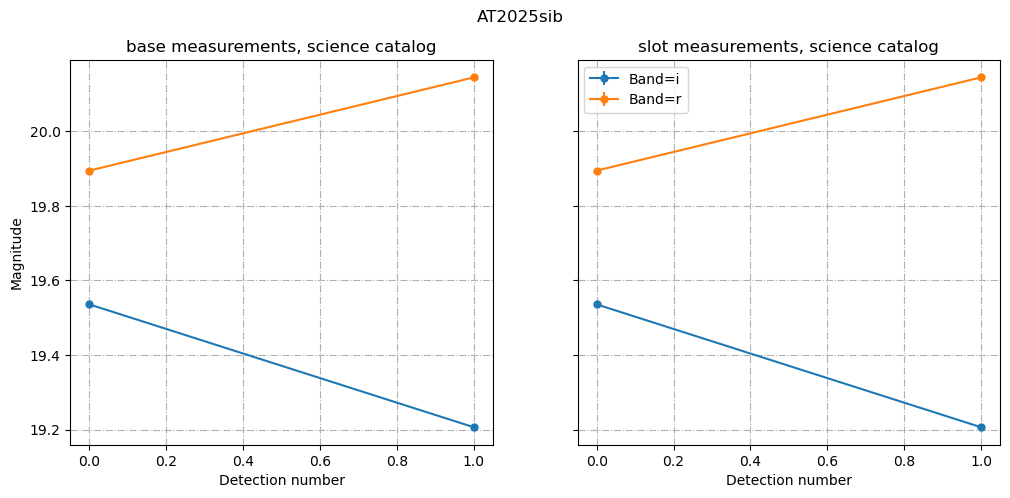

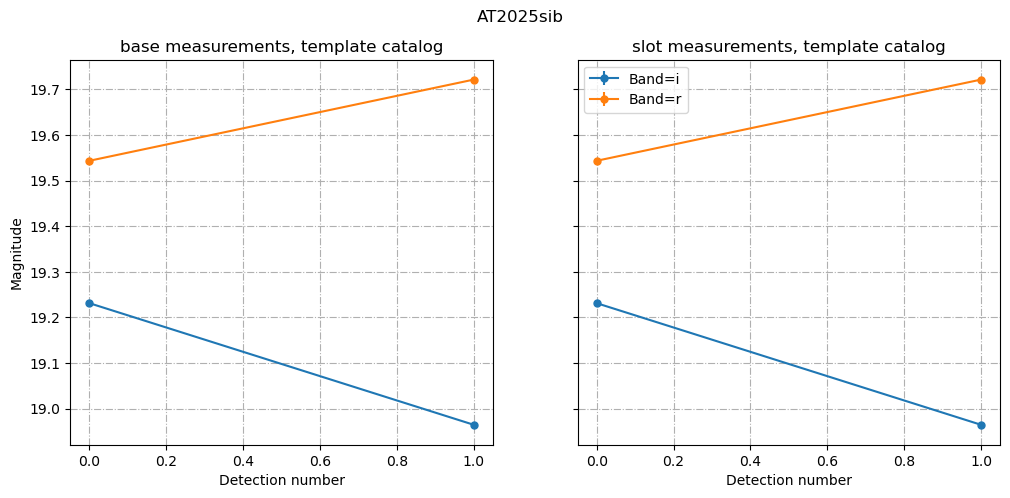

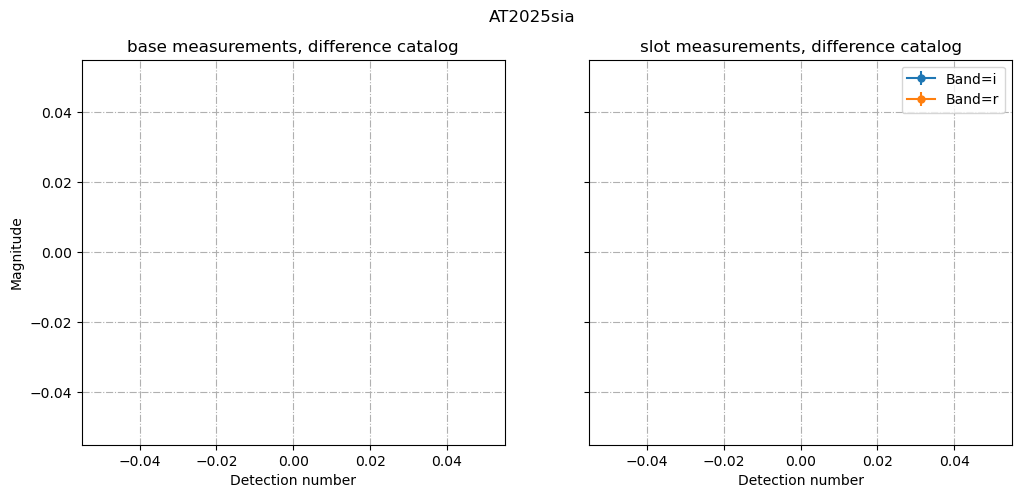

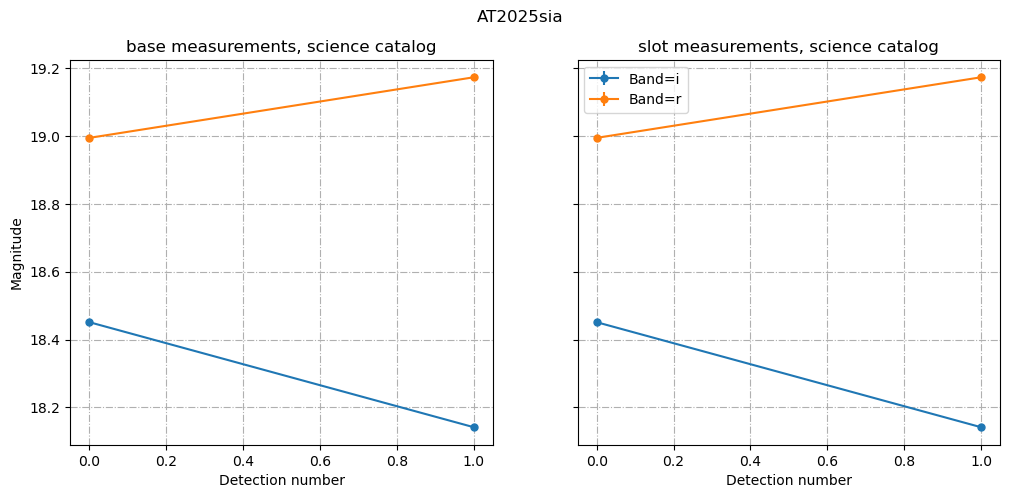

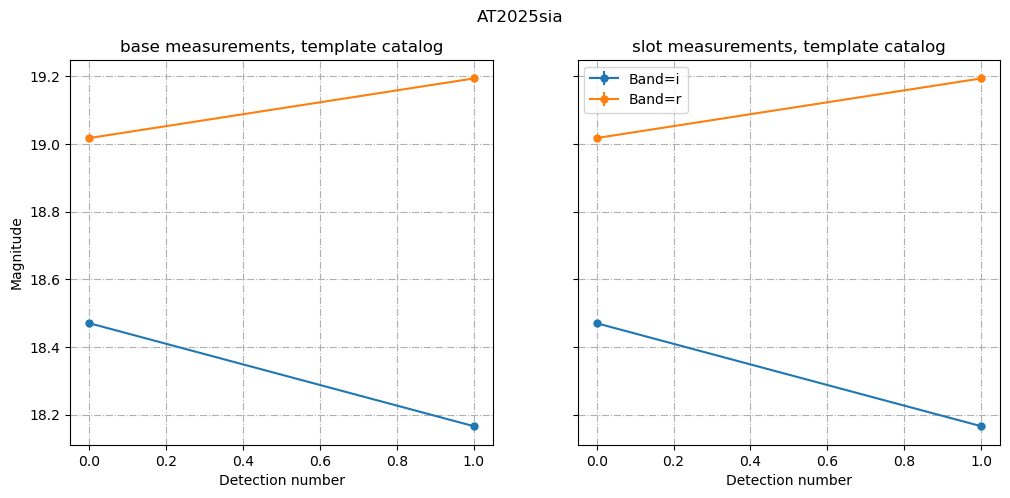

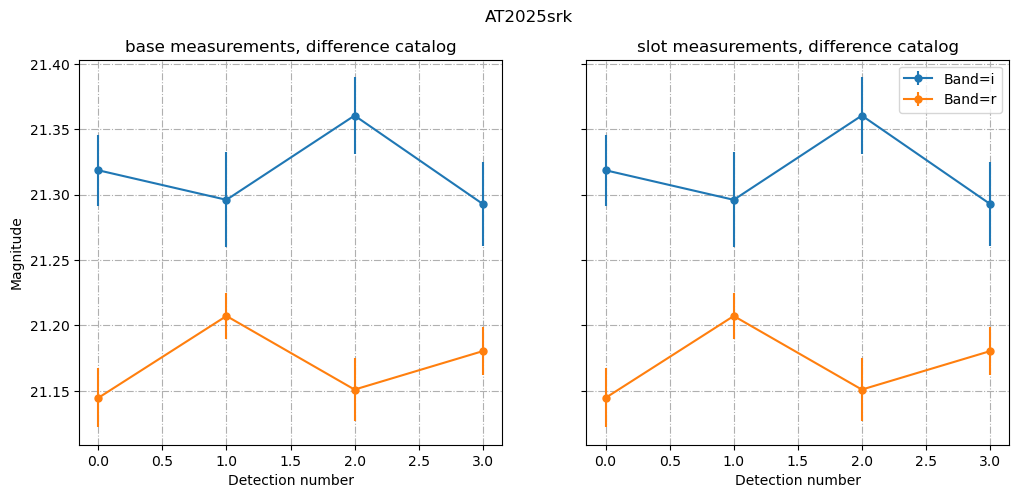

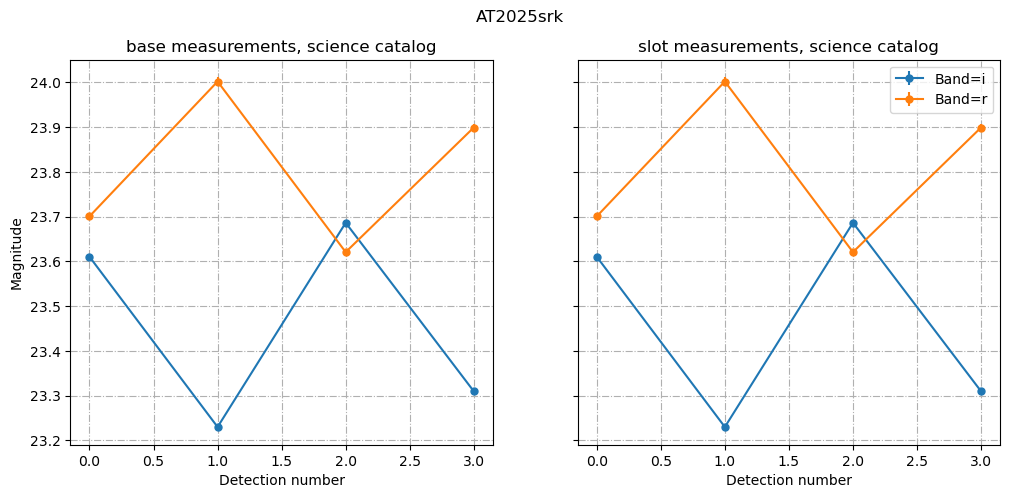

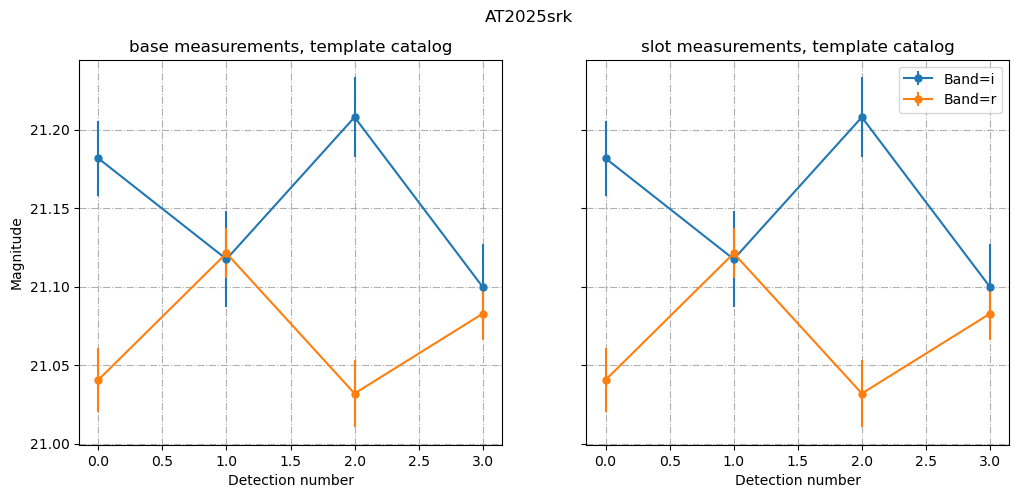

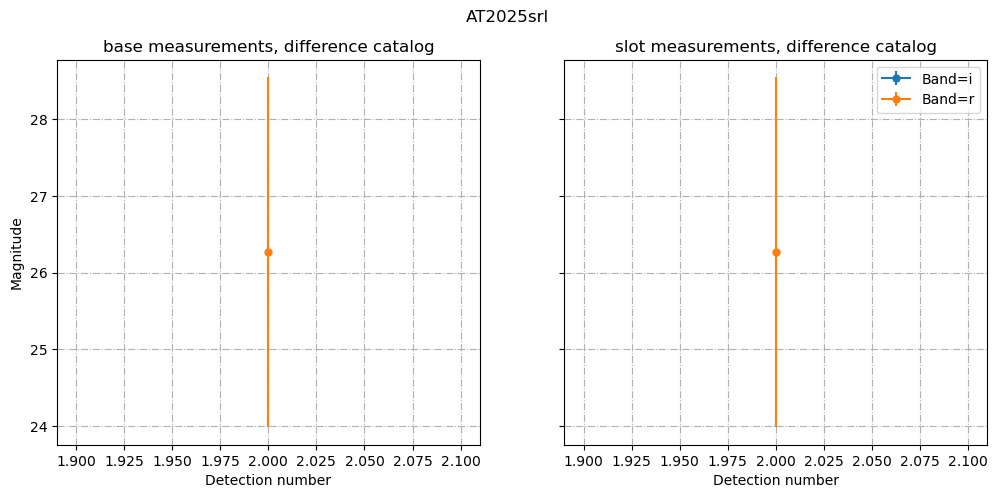

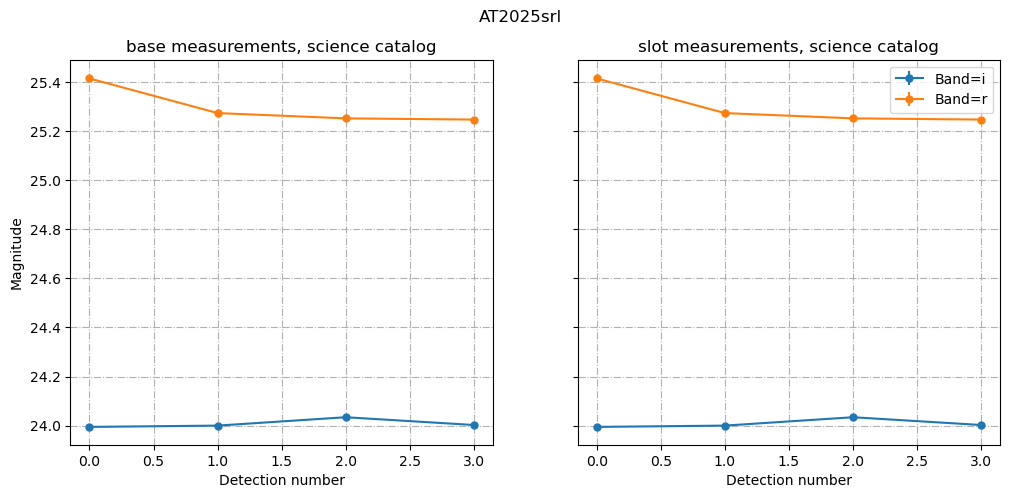

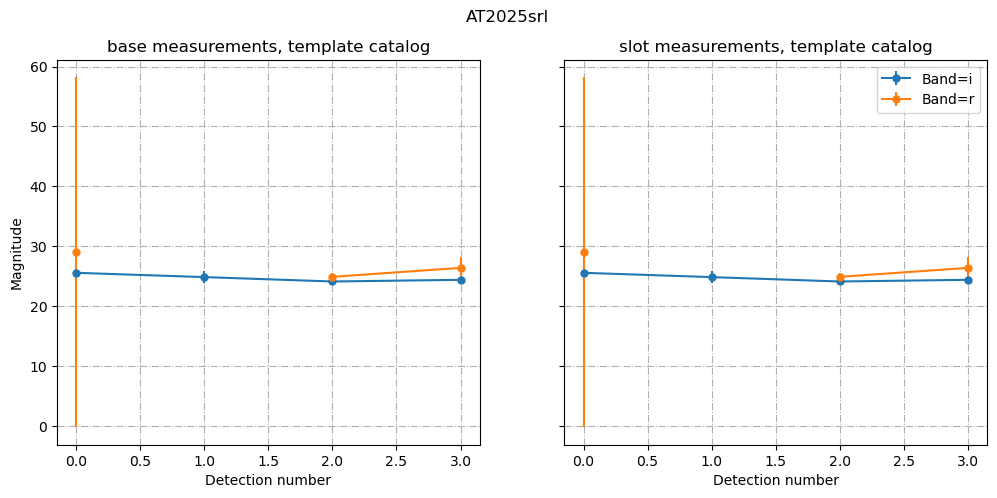

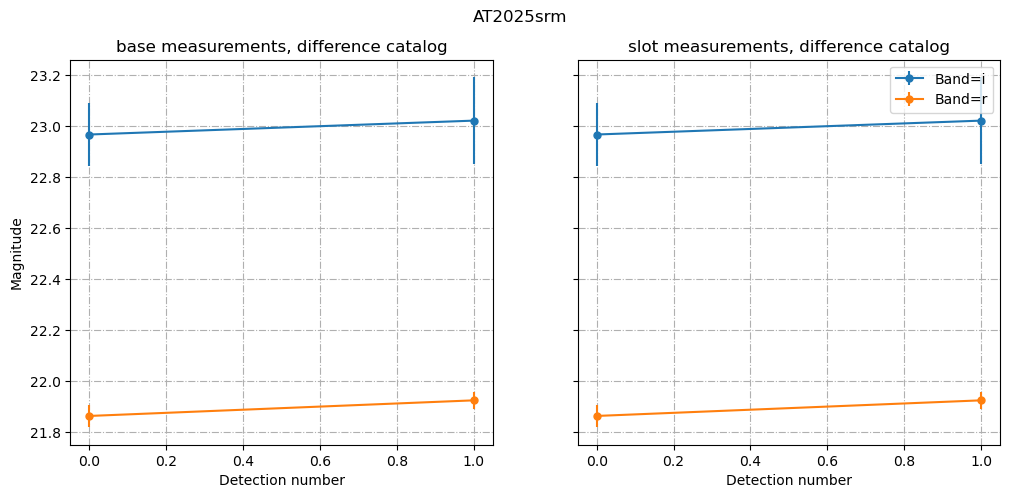

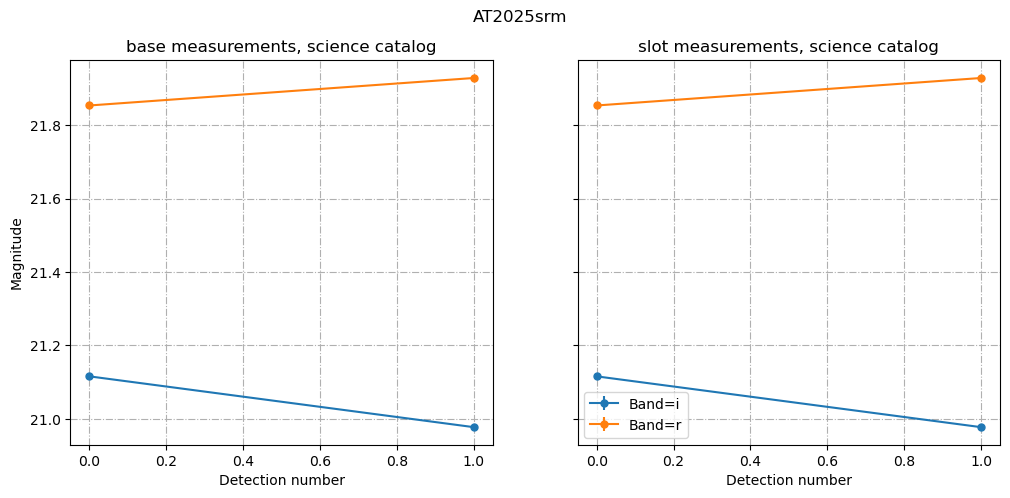

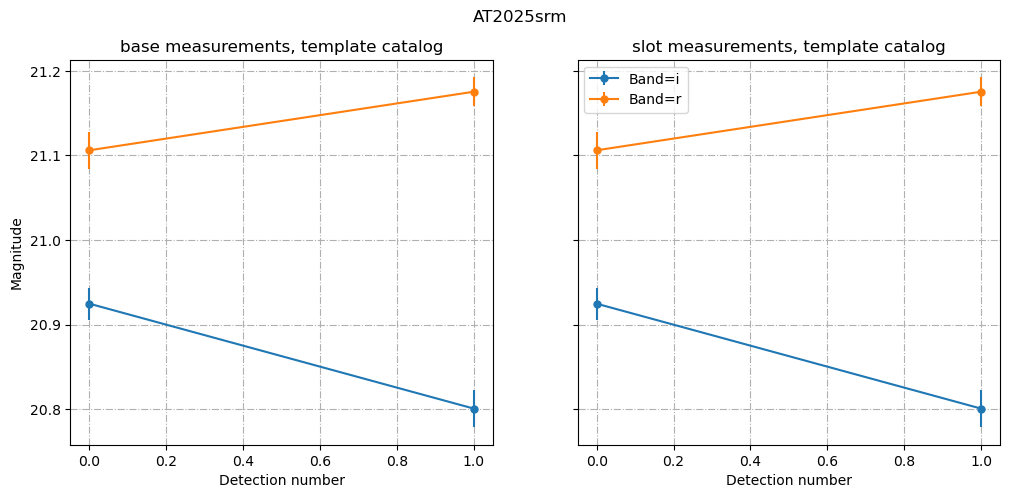

In [16]:
for i in np.unique(diffMasterCat["diaObjectId"]):
    # For each diaObject
    for cat,na in zip([diffMasterCat,tempMasterCat,sciMasterCat],
                     ["difference catalog","science catalog","template catalog"]):
        # For each catalog
        tname = names[i] # The transient name
        fig,axs = plt.subplots(1,2,sharey=True,figsize=(12,5))
        for a,n in zip(axs,["base","slot"]):
            
            for b in np.unique(cat["band"]):
                # For each band
                msk = np.logical_and(cat["diaObjectId"]==i, diffMasterCat["band"]==b)
                filteredCat = cat[msk]
                a.errorbar(np.arange(len(filteredCat)),filteredCat[n+"SourceMag"],
                           yerr=filteredCat[n+"SourceMagErr"],label="Band={}".format(b),marker=".",
                          markersize=10)
            a.set_xlabel("Detection number")
            a.set_title("{} measurements, {}".format(n,na))
            a.grid(ls="-.")
        a.legend()
        axs[0].set_ylabel("Magnitude")
        fig.suptitle("{}".format(tname))

In [17]:
for i in np.unique(diffMasterCat["diaObjectId"]):
    # For each diaObject
    tname = names[i] # The transient name
    print(tname)
    for cat,na in zip([diffMasterCat,tempMasterCat,sciMasterCat],
                     ["Difference catalog","Science catalog","Template catalog"]):
        # For each catalog
        print(na)
        for b in np.unique(cat["band"]):
            # For each band
            msk = np.logical_and(cat["diaObjectId"]==i, diffMasterCat["band"]==b)
            filteredCat = cat[msk]
            for n in ["base","slot"]:
                medMag = np.median(filteredCat[n+"SourceMag"])
                medMagErr = np.sqrt(np.sum(np.square(filteredCat[n+"SourceMagErr"])))
                print("Median magnitude, {} band, {} measurement: {}".format(b,n,medMag))
                print("Median magnitude errors added in quadrature, {} band, {} measurement: {}".format(b,n,medMagErr))
    print()

AT2025shz
Difference catalog
Median magnitude, i band, base measurement: 21.97189456783427
Median magnitude errors added in quadrature, i band, base measurement: 0.11332406257182444
Median magnitude, i band, slot measurement: 21.97189456783427
Median magnitude errors added in quadrature, i band, slot measurement: 0.11332406257182444
Median magnitude, r band, base measurement: 22.24514493370866
Median magnitude errors added in quadrature, r band, base measurement: 0.07699596420335292
Median magnitude, r band, slot measurement: 22.24514493370866
Median magnitude errors added in quadrature, r band, slot measurement: 0.07699596420335292
Science catalog
Median magnitude, i band, base measurement: 22.282330749788862
Median magnitude errors added in quadrature, i band, base measurement: 0.00021760182096315474
Median magnitude, i band, slot measurement: 22.282330749788862
Median magnitude errors added in quadrature, i band, slot measurement: 0.00021760182096315474
Median magnitude, r band, bas